# Generating Sound & Music with Evolutionary Algorithms

Evolutionary Algorithms are a subset of evolutionary computing; biologically inspired optimization with population-based trial and error search. Loosely speaking, an evolutionary algorithm creates a population of entities that can be modified, combined, and evaluated for fitness with respect to an optimization goal. The simplest optimization step works as follows; create a population, check which elements are most fit (best suited to the optimization problem), keep only the most fit, modify and recombine elements to create new element for the next generation, repeat.

### The components:
- genetic representation
- population
- genetic operations: mutation and recombination/crossover
- fitness
- selection
- sources of randomness


### Introduction Example:

Evolutionary algorithms are inspired by natural selection. Here is a simple simulation of natural selection (choose the lab): https://phet.colorado.edu/sims/html/natural-selection/latest/natural-selection_en.html

- note all the ways you can change the genetic operations
- note all the ways you can change the fitness function

## The evolutionary algorithm in this notebook

### The components in the code:
- genetic representation: ...
- population: ...
- genetic operations: 
1) point mutation of progression; ...
2) recombination of progression; ...
- fitness: 
1) penalize and encourage several pitch relationships between adjacent chords ...
2) penalize and encourage several pitch relationships between adjacent voices ...
- selection: ...
- sources of randomness: ...

### Getting to know the code:

1. understand the code below and get an overall idea of what the algorithm looks like, maybe draw a flow chart or take some notes. Replace the "..." with examples in the description of the components above. 
2. play around with the optimization loop while changing the modify function: do you see things that could be changed in the genetic representation? what are they and can you change them?
3. write a two step selection; first mutate/modify elements and select the fittest (with some randomness), then recombine them and select the fittest from offspring and parent elements (with some randomness)
4. change the modify function, such that some parts of the genetic representation (the chord sequence) can be fixed (made immutable). This is the most complex task and probably requires some thinking, creativity, and experimentation. Take your time!

In [23]:
import partitura as pt
import numpy as np
from scipy.spatial.distance import pdist
from itertools import product
import matplotlib.pyplot as plt
import os
from typing import Optional, Tuple, List


os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
from partitura.utils.fluidsynth import HAS_FLUIDSYNTH

if HAS_FLUIDSYNTH:
    from partitura.utils.fluidsynth import synthesize_fluidsynth as synthesize
else:
    from partitura.utils.synth import synthesize
import IPython.display as ipd
from helpers_EA import partFromFourPartProgression, randomword

## Four Part Harmony with EAs

Basic rules of four part harmony (super-simplified!):
- s - a : < octave
- a - t : < octave
- t - b : < 2 octave
- doublings: 1, 5, but not in 3
- bass: root / 1


In [24]:
chord_types = {
    # position 1: soprano in C
    "a": (10, 3, 4),
    "b": (3, 3, 4),
    "c": (12, 6, 6),
    "d": (5, 6, 6),
    # "e":(6,5,4), # 6
    # "f":(14,5,4), # 6
    # "g":(3,4,8), # 6
    # "h":(10,4,8), # 6
    # "i":(3,8,4), # 6 (5 doubled)
    # "j":(10,8,4), # 6 (5 doubled)
    # position 2: soprano in G
    "k": (8, 3, 3),
    "l": (1, 3, 3),
    "m": (5, 6, 3),  # (5 doubled)
    "n": (12, 6, 3),  # (5 doubled)
    "o": (3, 6, 5),
    "p": (10, 6, 5),
    "q": (3, 3, 8),  # (5 doubled)
    "r": (10, 3, 8),  # (5 doubled)
    # "s":(6,8,5), # 6
    # "t":(14,8,5), # 6
    # "u":(3,4,5), # 6 (5 doubled)
    # "v":(10,4,5), # 6 (5 doubled)
    # "w":(6,5,8), # 6 (5 doubled)
    # "x":(14,5,8), # 6 (5 doubled)
    # position 3: soprano in E
    "y": (1, 5, 6),
    "z": (8, 5, 6),
    "ö": (5, 4, 3),
    "ü": (12, 4, 3),
    "ä": (5, 8, 6),  # (5 doubled)
    ".": (12, 8, 6),  # (5 doubled)
}

In [25]:
class FourPartChord(object):
    """
    the Chord class representing a chord made of 4 notes of a scale.
    For diatonic scales the intervals between notes are thirds.

    Parameters
    ----------
    chord_type: str
        the type of the chord
    offset : int
        the MIDI pitch of scale degree 0
    scale : np.array
        the scale from which the chord is built

    """

    def __init__(
        self,
        chord_type: str = "a",
        offset: int = 48,
        scale: np.ndarray = np.array([0, 2, 4, 5, 7, 9, 11]),
    ):
        self.chord_type = chord_type
        self.offset = offset
        self.scale = scale
        lowest_offset = offset % 12
        self.whole_scale = np.concatenate(
            [self.scale + lowest_offset + 12 * octave for octave in np.arange(10)]
        )
        self.intervals = chord_types[self.chord_type]
        self.soprano = None
        self.alto = None
        self.tenor = None
        self.bass = None
        self.pitch_computed = False
        self.id = randomword(4)

    def compute_pitch(
        self,
        given_pitch: int,
        given_voice: int, 
    ):
        """Compute the pitches of the chord

        Parameters
        ----------
        given_pitch : int
            MIDI pitch of the given melody
        given_voice: int
            Voice (0-3) of the given melody
        

        Raises
        ------
        ValueError
            If note is not in the scale.
        """
        if not self.pitch_computed:
            given_note_idx = np.where(self.whole_scale == given_pitch)[0]
            if len(self.whole_scale) == 0:
                raise ValueError("given note needs to be in the scale")

            if given_voice == 0:
                self.soprano = self.whole_scale[given_note_idx]
                self.alto = self.whole_scale[given_note_idx - (self.intervals[2] - 1)]
                self.tenor = self.whole_scale[
                    given_note_idx - (self.intervals[2] - 1) - (self.intervals[1] - 1)
                ]
                self.bass = self.whole_scale[
                    given_note_idx
                    - (self.intervals[2] - 1)
                    - (self.intervals[1] - 1)
                    - (self.intervals[0] - 1)
                ]
            elif given_voice == 1:
                self.soprano = self.whole_scale[
                    given_note_idx + (self.intervals[2] - 1)
                ]
                self.alto = self.whole_scale[given_note_idx]
                self.tenor = self.whole_scale[given_note_idx - (self.intervals[1] - 1)]
                self.bass = self.whole_scale[
                    given_note_idx - (self.intervals[1] - 1) - (self.intervals[0] - 1)
                ]
            elif given_voice == 2:
                self.soprano = self.whole_scale[
                    given_note_idx + (self.intervals[2] - 1) + (self.intervals[1] - 1)
                ]
                self.alto = self.whole_scale[given_note_idx + (self.intervals[1] - 1)]
                self.tenor = self.whole_scale[given_note_idx]
                self.bass = self.whole_scale[given_note_idx - (self.intervals[0] - 1)]
            elif given_voice == 3:
                self.soprano = self.whole_scale[
                    given_note_idx
                    + (self.intervals[2] - 1)
                    + (self.intervals[1] - 1)
                    + (self.intervals[0] - 1)
                ]
                self.alto = self.whole_scale[
                    given_note_idx + (self.intervals[1] - 1) + (self.intervals[0] - 1)
                ]
                self.tenor = self.whole_scale[given_note_idx + (self.intervals[0] - 1)]
                self.bass = self.whole_scale[given_note_idx]

            self.pitch_computed = True

In [26]:
class FourPartProgression(object):
    """
    The Progression class representing a sequence of chords

    Parameters
    ----------
    c_type_sample : Optional[str], optional
        chord types, by default None
    number_of_chords : int, optional
        Number of chords in the sample, by default 8
    offset : int, optional
        _description_, by default 48
    scale : np.ndarray, optional
        _description_, by default np.array([0, 2, 4, 5, 7, 9, 11])
    """

    def __init__(
        self,
        c_type_sample: Optional[np.ndarray] = None,
        number_of_chords: int = 8,
        offset: int = 48,
        scale: np.ndarray = np.array([0, 2, 4, 5, 7, 9, 11]),  # This is the major scale
    ):
        """
        """
        self.scale = scale
        self.c_types = list(chord_types.keys())
        if c_type_sample is not None:

            if not all([ct in self.c_types for ct in c_type_sample]):
                raise ValueError(f"`c_type_sample` contains chords that are not in {self.c_types}")

            if len(c_type_sample) != number_of_chords:
                number_of_chords = len(c_type_sample)

            self.c_type_sample = c_type_sample

        else:
            self.c_type_sample = np.random.choice(
                self.c_types,
                number_of_chords,
            )
        self.chords = [
            FourPartChord(
                self.c_type_sample[c],
                offset=offset,
                scale=self.scale,
            )
            for c in range(number_of_chords)
        ]
        self.number_of_chords = number_of_chords
        self.id = randomword(10)

    def copy(self) -> "FourPartProgression":
        return FourPartProgression(
            number_of_chords=self.number_of_chords,
            c_type_sample=self.c_type_sample,
            scale=self.scale,
        )

    def set_voice(
        self,
        melody: np.ndarray,
        voice: int,
    ) -> None:
        for cidx, melody_pitch in enumerate(melody):
            self.chords[cidx].compute_pitch(melody_pitch, voice)

    def point_mutate(
        self,
        idx: Optional[int] = None,
        c_type_sample: Optional[str] = None,
    ) -> None:
        if idx is None:
            idx = np.random.randint(0, self.number_of_chords)
        if c_type_sample is None:
            c_type_sample = np.random.choice(self.c_types, 1)
        self.c_type_sample[idx] = c_type_sample[0]
        self.chords[idx] = FourPartChord(c_type_sample[0])

    def join(
        self,
        another: "FourPartProgression",
        idx: Optional[int] = None,
    ) -> Tuple["FourPartProgression", "FourPartProgression"]:
        """
        create two new progressions by joining two existing ones
        where the split of chords is defined by an index array
        """
        if another.number_of_chords != self.number_of_chords:
            raise ValueError("progressions must have the same number of chords")

        if idx is None:
            idx = np.unique(
                np.random.randint(0, self.number_of_chords, self.number_of_chords // 2)
            )

        new_progression = FourPartProgression(number_of_chords=self.number_of_chords)
        new_another_progression = FourPartProgression(
            number_of_chords=self.number_of_chords
        )
        for k in range(self.number_of_chords):
            if k in idx:
                new_progression.chords[k] = self.chords[k]
                new_another_progression.chords[k] = another.chords[k]
            else:
                new_progression.chords[k] = another.chords[k]
                new_another_progression.chords[k] = self.chords[k]
        return new_progression, new_another_progression

## Optimization loop

In [ ]:
class FourPartOptimizer(object):
    def __init__(self):
        self.population = None

    def modify(
        self,
        population: List[FourPartProgression],
        number_to_mutate: int,
        number_to_recombine: int,
    ) -> List[FourPartProgression]:
        # point mutation of chord
        subpop4 = np.random.choice(population, number_to_mutate)
        for element in subpop4:
            cidx = np.random.randint(len(element.chords))
            new_element = element.copy()
            new_element.point_mutate(cidx)
            population.append(new_element)

        # recombination of sequence
        subpop1 = np.random.choice(population, number_to_recombine)
        subpop2 = np.random.choice(population, number_to_recombine)
        for element0, element1 in zip(subpop1, subpop2):
            elnew1, elnew2 = element0.join(element1)
            population.append(elnew1)
            population.append(elnew2)

        return population

    def fitness(
        self,
        progression: FourPartProgression,
        melody: np.ndarray,
        voice: int,
    ) -> float:
        progression.set_voice(melody, voice)
        index_range = (0, progression.number_of_chords)
        fit = 0.0
        for c0, c1 in zip(
            progression.chords[index_range[0] : index_range[1]],
            progression.chords[index_range[0] + 1 : index_range[1] + 1],
        ):
            melodic_lines = np.array(
                [
                    c1.soprano - c0.soprano,
                    c1.alto - c0.alto,
                    c1.tenor - c0.tenor,
                ]
            )
            melodic_lines_bass = np.array(
                [
                    c1.soprano - c0.soprano,
                    c1.alto - c0.alto,
                    c1.tenor - c0.tenor,
                    c1.bass - c0.bass,
                ]
            )
            fit += np.sum(np.abs(melodic_lines))  # penalize large leaps
            if (melodic_lines_bass > 0).sum() >= 3:
                fit += 5  # similar motion
            elif (melodic_lines_bass < 0).sum() >= 3:
                fit += 5  # similar motion

            intervals0 = np.array(
                [
                    c0.soprano - c0.alto,
                    c0.alto - c0.tenor,
                    c0.soprano - c0.tenor,
                ]
            )
            intervals1 = np.array(
                [
                    c1.soprano - c1.alto,
                    c1.alto - c1.tenor,
                    c1.soprano - c1.tenor,
                ]
            )
            for i0, i1 in zip(intervals0, intervals1):
                if i0 == i1:
                    if np.abs(i0) == 7:
                        fit += 10  # parallel fifths
                    elif np.abs(i0) == 12:
                        fit += 10  # parallel octave

        # add a small random number for hashing
        fit += np.random.rand(1)[0]
        return float(fit)

    def select(
        self,
        population: List[FourPartProgression],
        melody: np.ndarray,
        voice: int,
        number_to_keep: int,
    ) -> Tuple[
        List[FourPartProgression],
        List[float],
        FourPartProgression,
    ]:
        pop = {ele.id: ele for ele in population}
        fitness_dict = {self.fitness(ele, melody, voice): ele.id for ele in population}
        sorted_fitness = list(fitness_dict.keys())
        sorted_fitness.sort()
        new_pop = [pop[fitness_dict[k]] for k in sorted_fitness[:number_to_keep]]
        best_prog = pop[fitness_dict[sorted_fitness[0]]]
        return new_pop, sorted_fitness, best_prog

    def run(
        self,
        epochs: int = 200,
        population_size: int = 100,
        replacement_ratio: float = 0.2,
        mutation_ratio: float = 0.2,
        combination_ratio: float = 0.2,
        new_population: bool = True,
        melody: np.ndarray = np.array([48, 50, 53, 48, 50, 47, 43, 48]),
        voice: int = 3,
        number_of_chords: int = 8,
        save_part: int = 40,
    ) -> Tuple[List[FourPartProgression], pt.score.Part]:

        part = None
        number_to_keep = int(np.round((1 - replacement_ratio) * population_size))
        number_to_sample = int(np.round((replacement_ratio) * population_size))
        number_to_mutate = int(np.round(mutation_ratio * population_size))
        number_to_recombine = int(np.round(combination_ratio * population_size))

        if new_population:
            population = [
                FourPartProgression(number_of_chords=number_of_chords)
                for po in range(population_size)
            ]
        else:
            population = self.population

        for epoch in range(epochs):

            # Test quality of candidate solutions and select the ones
            # to reproduce
            population, sorted_fitness, best_prog = self.select(
                population,
                melody,
                voice,
                number_to_keep,
            )

            # Produce new variations of selected solutions
            population = self.modify(
                population,
                number_to_mutate,
                number_to_recombine,
            )
            print(f"Epoch {epoch} best fitness: {sorted_fitness[0]:.4f}")
            if epoch % save_part == 0:
                part = partFromFourPartProgression(
                    best_prog,
                    part=None,
                    # part=part,
                    quarter_duration=1,
                    # time_offset=(epoch // save_part) * number_of_chords,
                    time_offset=0,
                )

            population += [
                FourPartProgression(number_of_chords=number_of_chords)
                for po in range(number_to_sample)
            ]

        self.population = population

        pt.score.add_measures(part)

        return self.population, part

In [28]:
melody = np.array([60, 62, 64, 60, 60, 62, 64, 60, 64, 66, 67, 67, 64, 66, 67, 67])
exp = FourPartOptimizer()
pop, part = exp.run(
    epochs=100,
    population_size=50,
    replacement_ratio=0.2,
    mutation_ratio=0.2,
    combination_ratio=0.2,
    new_population=True,
    melody=melody,
    voice=0,
    number_of_chords=len(melody),
    save_part=40,
)

/var/folders/5p/mwrb5k_s7v1gdc_99g3tl7tr0000gn/T/ipykernel_76686/1036717707.py:78: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i0 == i1:


Epoch 0 best fitness: 118.0440
Epoch 1 best fitness: 117.0424
Epoch 2 best fitness: 117.3128
Epoch 3 best fitness: 105.5013
Epoch 4 best fitness: 105.1062
Epoch 5 best fitness: 105.3084
Epoch 6 best fitness: 100.6014
Epoch 7 best fitness: 84.6879
Epoch 8 best fitness: 84.5702
Epoch 9 best fitness: 83.6513
Epoch 10 best fitness: 80.3419
Epoch 11 best fitness: 80.3252
Epoch 12 best fitness: 80.5101
Epoch 13 best fitness: 80.4997
Epoch 14 best fitness: 80.1296
Epoch 15 best fitness: 80.3942
Epoch 16 best fitness: 79.8156
Epoch 17 best fitness: 79.8180
Epoch 18 best fitness: 79.7551
Epoch 19 best fitness: 79.7688
Epoch 20 best fitness: 79.6165
Epoch 21 best fitness: 73.2770
Epoch 22 best fitness: 73.5467
Epoch 23 best fitness: 70.6503
Epoch 24 best fitness: 63.1840
Epoch 25 best fitness: 63.3797
Epoch 26 best fitness: 63.8230
Epoch 27 best fitness: 59.8808
Epoch 28 best fitness: 59.3243
Epoch 29 best fitness: 59.2590
Epoch 30 best fitness: 58.0495
Epoch 31 best fitness: 58.0428
Epoch 32 be

In [29]:
pt.save_musicxml(part, "evolutionary_four_part_writing.musicxml")

In [30]:
na = part.note_array()

unique_onsets = np.unique(na["onset_beat"])
unique_onset_idxs =  [np.where(na["onset_beat"] == u)[0] for u in unique_onsets]

print([len(uix) for uix in unique_onset_idxs])

print(len(unique_onsets))

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
42


## Synthesize

In [31]:
SAMPLE_RATE = 44100

audio = synthesize(part, samplerate=SAMPLE_RATE)
audio /= 4  # a bit quieter
ipd.display(ipd.Audio(data=audio, rate=SAMPLE_RATE, normalize=False))

## Visualize

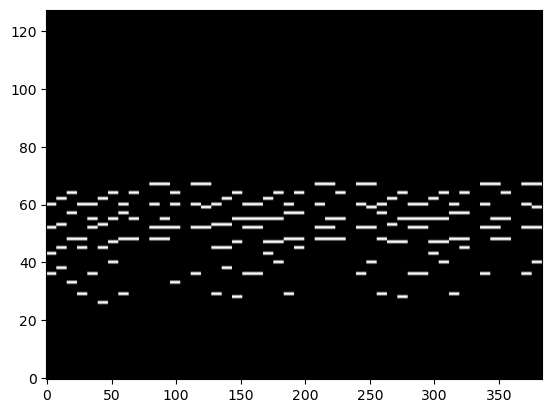

In [32]:
piano_roll = pt.utils.music.compute_pianoroll(part)
plt.imshow(
    piano_roll.toarray(),
    aspect="auto",
    origin="lower",
    cmap="gray",
)
plt.show()